In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from LERGfunc import *
%matplotlib inline
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import skew
from scipy.signal import chirp
from signal import find_peaks,peak_widths

In [2]:
def popt_central_fit(wo_wave,data,error,z):
    k = 1+z
    v_core = 0.0
    sigma_core = 10.0
    sigma_wing = 100.0
    select = (wo_wave>4900) & (wo_wave<5100)
    v_wing = 100
    popt_full_fit,pcov_full_fit = leastsq(full_gauss_O3,x0=[3,v_core,sigma_core,0.5,v_wing,sigma_wing,-0.001,0.1],args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 10
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss_O3,x0=[3,v_core,sigma_core,0.5,v_wing,sigma_wing,-0.001,0.1],args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    return popt_full_fit,parameters_err 

def lum_OIII(amp_OIII5007,vel_sigma_OIII,z):
    sigma_wing = line_width_recons(vel_sigma_OIII,rest_line=5006.8,inst_res_fwhm=0)
    flux_wing = amp_OIII5007*(2.*np.pi)*np.fabs(sigma_wing)
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    log_wing_lum = np.log10(4*np.pi) + 2*np.log10(dist.value) + np.log10(flux_wing) - 17
    return log_wing_lum

def edd_ratio(log_L_OIII,vel_sigma_star):
    vel_sigma_ratio = (vel_sigma_star/200)**(4.02)
    const = 2.06*(10**(-43))
    L_OIII = 10**(log_L_OIII)
    edd_rat = (const*L_OIII)/vel_sigma_ratio
    return edd_rat

def OIII_sigma(z,mini_wave,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_OIII_br,vel_OIII_br,vel_sigma_OIII_br):
    c = 300000
    k = 1+z
    select = (mini_wave>4990*k) & (mini_wave < 5020*k)
    m = OIII_model(mini_wave[select],amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_OIII_br,vel_OIII_br,vel_sigma_OIII_br)
    m_0 = np.sum(m)
    m_1 = np.sum(mini_wave[select]*m)/m_0
    m_2 = np.sqrt(np.sum(m*(mini_wave[select]-m_1)**2)/m_0)

    sigma_OIII_tot = c*(m_2)/m_1
    return sigma_OIII_tot

In [3]:
def result_and_plot(wo_wave,data,error,z,popt_full_fit,parameters_err,plateid,mjd,fiberid,log_L_radio,vel_sigma_star,RA,DEC,destination_path_cube="raw/spectro/1d_26"):
    (amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,m_fit,c_fit) = popt_full_fit
    (amp_OIII5007_err,vel_OIII_err,vel_sigma_OIII_err,amp_OIII5007_br_err,vel_OIII_br_err,vel_sigma_OIII_br_err,m_err,c_err) = parameters_err

    k = 1+z
    select = (wo_wave>4900) & (wo_wave<5050)
    select2 = (wo_wave>4990) & (wo_wave<5020)
    select_emission = (wo_wave>4997) & (wo_wave<5017)
    select_noise = (wo_wave>4970) & (wo_wave<4990)
    
    fit = full_gauss_O3(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
       
    vel_sigma_OIII_1 = np.abs(vel_sigma_OIII_fit)
    vel_sigma_OIII_2 = np.abs(vel_sigma_OIII_br_fit)
    if vel_sigma_OIII_1 < vel_sigma_OIII_2:
        core = O3_gauss(wo_wave[select2],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit)
        wing = O3_gauss(wo_wave[select2],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit)
    else:
        wing = O3_gauss(wo_wave[select2],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit)
        core = O3_gauss(wo_wave[select2],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit)
    
    err_core = error[select2]
    max_location_core = np.where(core == np.amax(core))[0][0]
    AN_core = (core[max_location_core]/err_core[max_location_core])
    
    err_wing = error[select2]
    max_location_wing = np.where(wing == np.amax(wing))[0][0]
    AN_wing = (wing[max_location_wing]/err_wing[max_location_wing])
    true_vel_offset = np.abs(vel_OIII_fit - vel_OIII_br_fit) - np.sqrt((vel_OIII_err)**2+(vel_OIII_br_err)**2)
    log_L_OIII_br = lum_OIII(amp_OIII5007_br_fit,vel_sigma_OIII_br_fit,z)
    log_L_OIII_nr = lum_OIII(amp_OIII5007_fit,vel_sigma_OIII_fit,z)
    log_L_OIII = np.log10(10**(log_L_OIII_nr) + 10**(log_L_OIII_br))
    ratio_edd = edd_ratio(log_L_OIII,vel_sigma_star)
    
    if AN_core > 3 and AN_wing > 3 and vel_sigma_OIII_br_fit < 1000 and np.abs(vel_sigma_OIII_br_fit) > np.abs(vel_sigma_OIII_br_err) and np.abs(vel_sigma_OIII_fit) > np.abs(vel_sigma_OIII_err) and true_vel_offset >0 and ratio_edd < 0.01:
        print (popt_full_fit,parameters_err)
        print (plateid,mjd,fiberid)
        log_L_bol = np.log10(3500) + log_L_OIII
        log_p_jet = 0.75*log_L_radio + 26.02
        
        amp_emission = data[select_emission]
        amp_noise = data[select_noise]
        amp_to_noise = amp_emission/amp_noise
        
        noise_data = data[select_noise]

        peaks, _ = find_peaks(noise_data)
        results_half = peak_widths(noise_data, peaks, rel_height=0.0)
        print("Noise Width is,",results_half[0])
        
        Monte_Carlo_loops = 100
        par_MC = np.zeros((5,Monte_Carlo_loops))
        for l in range(Monte_Carlo_loops):
            log_L_OIII_br_iter = lum_OIII(np.random.normal(amp_OIII5007_br_fit,amp_OIII5007_br_err),np.random.normal(vel_sigma_OIII_br_fit,vel_sigma_OIII_br_err),z)
            log_L_OIII_nr_iter = lum_OIII(np.random.normal(amp_OIII5007_fit,amp_OIII5007_err),np.random.normal(vel_sigma_OIII_fit,vel_sigma_OIII_err),z)
            log_L_OIII_iter = np.log10(10**(log_L_OIII_nr_iter) + 10**(log_L_OIII_br_iter))
            log_p_jet_iter = np.random.normal(0.75,0.14)*log_L_radio + np.random.normal(26.02,0.18)
            log_L_bol_iter = np.log10(3500) + log_L_OIII_iter

            par_MC[:,l]=[log_L_OIII_br_iter,log_L_OIII_nr_iter,log_L_OIII_iter,log_p_jet_iter,log_L_bol_iter]
        par_err = np.nanstd(par_MC,1)  
        (log_L_OIII_br_err,log_L_OIII_nr_err,log_L_OIII_err,log_p_jet_err,log_L_bol_err) = par_err
    
        full_par = [RA,DEC,log_L_radio,log_L_OIII_br,log_L_OIII,ratio_edd,log_L_bol,log_p_jet,z]
        full_err = [0,0,0,log_L_OIII_br_err,log_L_OIII_err,0,log_L_bol_err,log_p_jet_err,0]
        print (log_L_radio,log_L_OIII_br,log_L_OIII,ratio_edd,log_p_jet,RA,DEC,z)
        print ("A/N ratio is",amp_to_noise)
        print ("A/N ratio is",amp_to_noise)
        #central_table(popt_full_fit,parameters_err,plateid,mjd,fiberid)
        #par_table(full_par,full_err,plateid,mjd,fiberid)
        
        fig = plt.gcf()
        fig.set_size_inches(9, 6)
        plt.plot(wo_wave[select],fit,'r:',label='fit')
        plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
        plt.plot(wo_wave[select],fit,color='gray',label='data',drawstyle='steps-mid',lw = 3)
        plt.plot(wo_wave[select],O3_gauss(wo_wave[select],amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
        plt.plot(wo_wave[select],O3_gauss(wo_wave[select],amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
        plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
        plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
        plt.legend(fontsize=15)
        plt.show()     
        #fig.savefig('LERG Plots/Fit/spSpec-%s-%s-%s_full_fit.png'%(plateid,mjd,fiberid),dpi = 600,overwrite=True)

        fig = plt.gcf()
        fig.set_size_inches(9, 3)
        plt.plot(wo_wave[select],residual/error[select],drawstyle='steps-mid',color='black')
        plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
        plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
        plt.ylabel(r"Residual/Error",fontsize=15)
        plt.legend(fontsize=15)
        plt.show()     
        #fig.savefig('LERG Plots/Residual/spSpec-%s-%s-%s_residual_fit.png'%(plateid,mjd,fiberid),dpi = 600,overwrite=True)

    else:
        pass
    

In [4]:
def central_table(popt_full_fit,parameters_err,plateid,mjd,fiberid,destination_path_cube="LERG/Spectral Parameters"):
    popt = popt_full_fit
    column_names={'amp_OIII5007':0,'vel_OIII':1,'vel_sigma_OIII':2,'amp_OIII5007_br':3,'vel_OIII_br':4,
              'vel_sigma_OIII_br':5,'m':6,'c':7}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt_full_fit[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[parameters_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/spSpec-%s-%s-%s_central_fit.fits'%(destination_path_cube,plateid,mjd,fiberid),overwrite=True)
    
def par_table(full_par,full_err,plateid,mjd,fiberid,destination_path_cube="LERG/Big Table"):
    column_names={'RA':0,'DEC':1,'log_L_radio':2,'log_L_OIII_br':3,'log_L_OIII':4,'r_edd':5,'log_L_bol':6,'log_P_jet':7,'z':8}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[full_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[full_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/spSpec-%s-%s-%s_spec_par.fits'%(destination_path_cube,plateid,mjd,fiberid),overwrite=True)

In [5]:
hdu_tab = fits.open('LERG_cord.fits')
tab = hdu_tab[1].data
PLATEID = tab['PLATEID']
MJD = tab['MJD']
FIBERID = tab['FIBERID']
log_radio_power = tab['log_L_radio']
ratio_edd = tab['edd ratio']
vel_sigma_stellar = tab['vel_sigma_stellar']
ra = tab['RA']
dec = tab['DEC']
source_no = len(MJD)
hdu_tab.close()
#central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)

[   4.90554969  168.8836118   119.74497984    4.52723591 -235.44491084
  413.07065557   -4.86281968   23.97283177] [   1.04511818   73.7787383    99.60435564    1.07719231  365.1454629
  107.53289173    1.48649097    7.4420847 ]
0680 52200 030
24.743 40.6881526057 40.8066841505 0.00855515901154 44.5772385788 351.795 -0.699397 0.0990425


/usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in log10


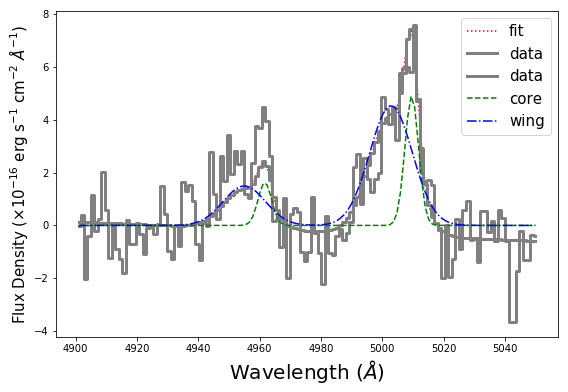

/usr/local/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


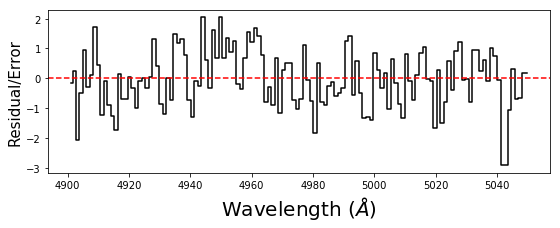

[   3.30704886   91.45822665  178.65968562    2.58229987 -198.79175139
  438.72411079   -3.69290985   18.26978984] [   1.16634929   55.99293785   68.51263752    0.66583406  257.49865602
  151.54492431    0.97915512    4.90361913]
2661 54505 545
24.4128 41.0961066732 41.2782545247 0.00832816129106 44.3296199036 193.75 25.5422 0.191954


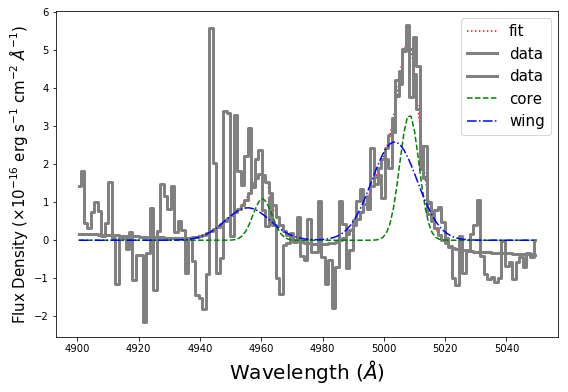

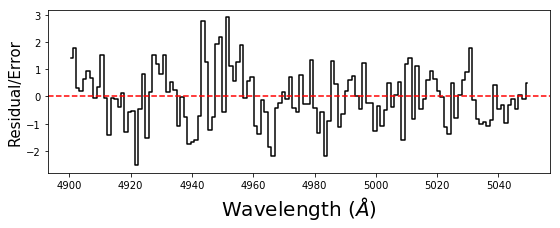

[   8.46182476  141.12045044  134.21653474    5.53295076 -207.08655497
  236.02337208  -10.95348049   54.55188358] [   1.53181859   45.9259453    35.43910004    1.44461827   93.9900128
  100.79117115    1.77760867    8.89416131]
1869 53327 527
23.3864 40.0052878214 40.2769859324 0.00204282938081 43.5598359299 119.109 51.276 0.0556597


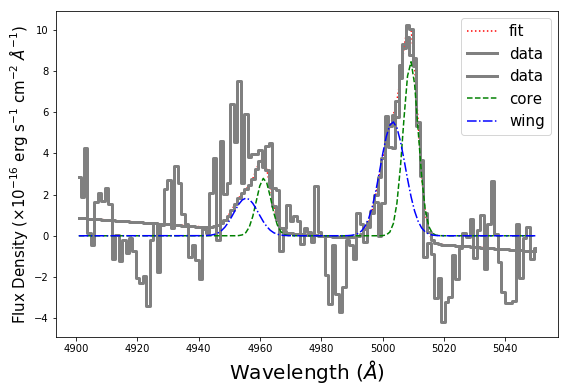

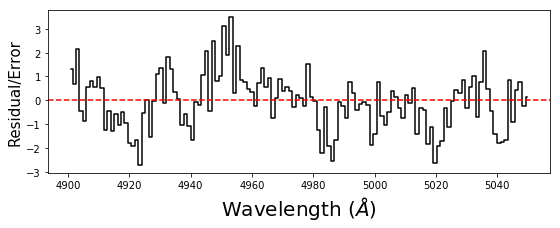

[  12.72461728   98.08148367  135.57859805    8.16354474 -384.38289989
  276.32752325  -10.9104718    53.78053554] [   1.53547612   29.25515711   29.14269139    0.92633177   76.49459429
  180.58458974    2.27235973   11.3721542 ]
0690 52261 207
25.6992 40.495814571 40.7424152477 0.00650058821978 45.2943782997 9.26712 -1.15233 0.0735527


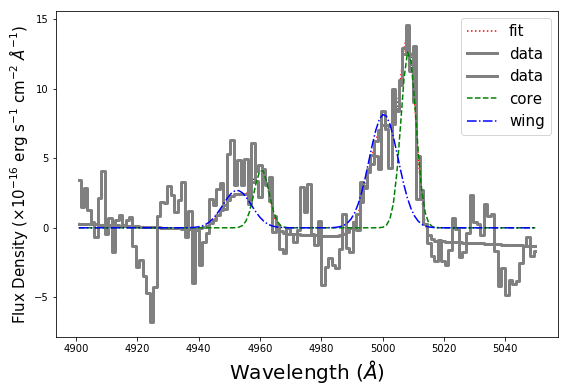

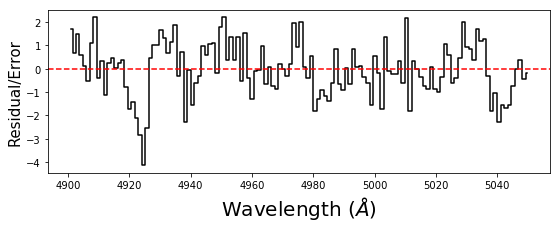

[   9.53867468  135.85340033  131.41266873   11.61332457 -216.07572518
  264.9690227    -9.98712724   49.70296678] [ 209.07195742  141.32119054   73.38046817  210.56886452  128.30713463
  203.52745057    2.87483717   14.39726559]
1292 52736 507
23.6546 40.5211511777 40.6694990076 0.00859194657459 43.7609529686 229.662 40.7501 0.0652207


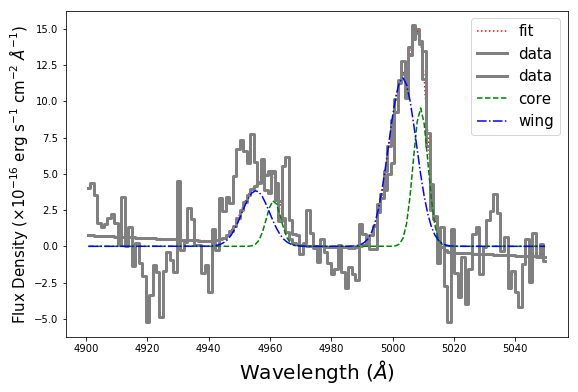

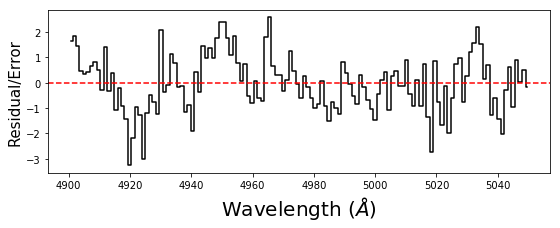

[  23.36531103   62.04094085  127.16474996    6.46731045 -425.88675281
  294.33013034  -18.58609356   92.03545475] [  1.80069382  18.13150227  17.90843474   1.25133695  93.59706542
  49.71762679   3.05513958  15.29569934]
1428 52998 463
23.3592 40.2664674509 40.6747154063 0.00286403525802 43.5393753242 156.421 39.1795 0.0619884


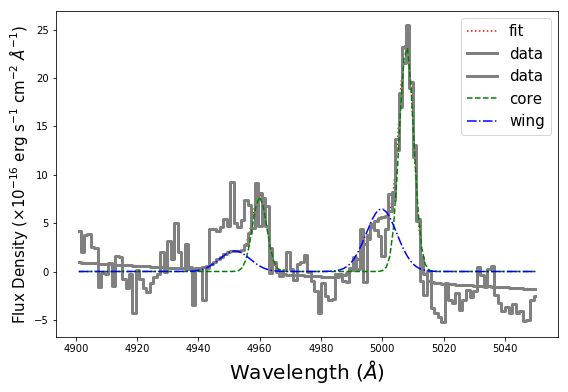

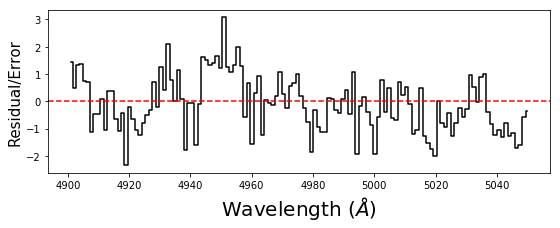

[  19.23804664  100.56744347  156.37571334    4.0798737  -408.92763493
  329.06825074   -1.80669325    8.90572328] [   1.02316686   11.83382538   10.98897573    0.74915685  102.61214972
   87.10648879    1.49222359    7.48980156]
2117 54115 264
25.3517 39.8298683719 40.3403438038 0.00405529232228 45.0337562752 208.075 31.4463 0.0451884


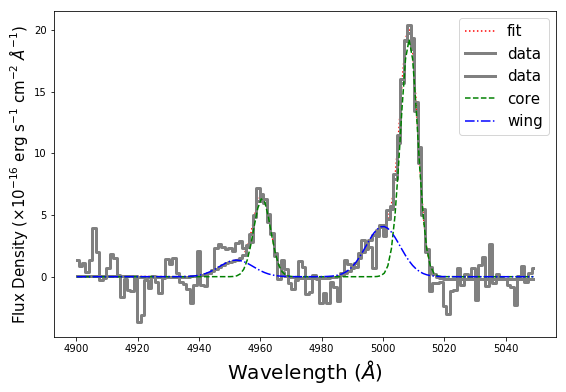

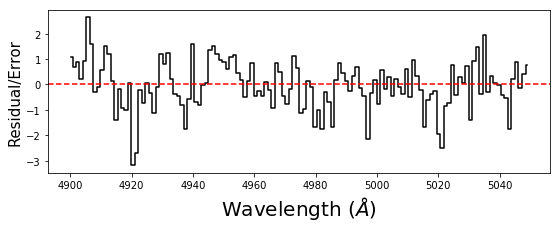

[  10.93349278  121.53581527  128.04237357    7.25690431  -38.73185325
  355.78544533   -1.80908183    8.6959929 ] [  1.56858179  18.15825122  29.3129167    1.45144987  66.58656222
  49.87888037   1.29553074   6.50189724]
1018 52672 227
22.4921 40.1860851894 40.3741146736 0.0077776445385 42.889073391 180.667 54.7834 0.0489694


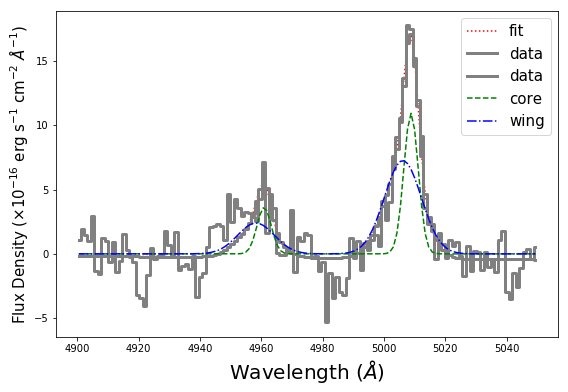

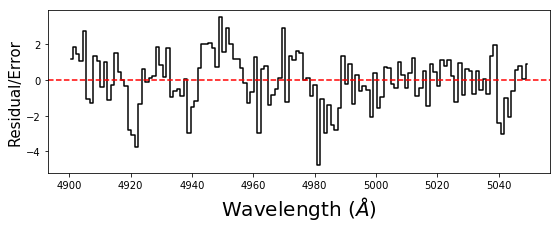

[  22.94803591   94.59972892  176.90041447   16.152747   -290.23747718
  289.61138881  -24.4705572   121.42589225] [ 345.51642188  125.50003439   60.32401516  348.52070905  252.87430468
  182.6972747     3.41221512   17.06992137]
2285 53700 633
23.0885 39.9439981585 40.2152492779 0.00180518556804 43.3364000511 137.406 19.469 0.0279609


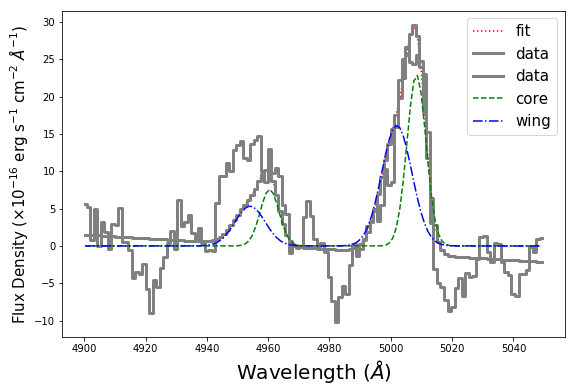

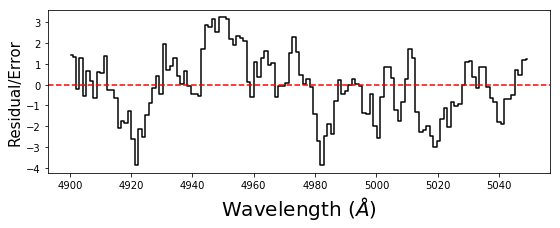

[  34.45486407  108.32100198  162.09073813    7.43030102 -381.40922274
  305.81396014  -12.91979708   63.70150267] [  1.68188271  10.67590538  10.48707961   1.10543621  77.98625764
  28.01333138   2.74993815  13.78794735]
2131 53819 533
24.3606 39.8838124387 40.4224632382 0.00693439561044 44.2904868317 216.169 26.6251 0.0371782


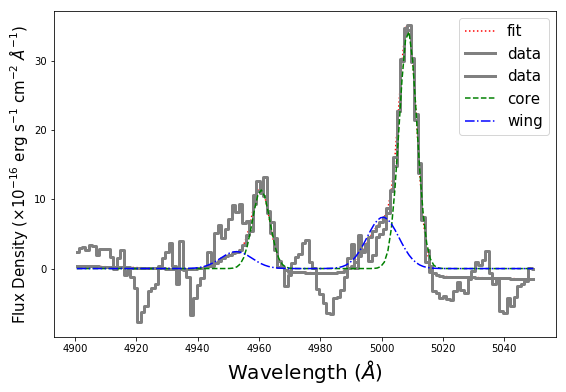

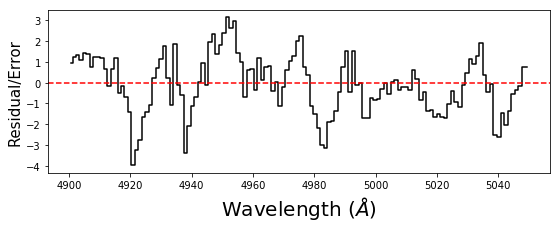

[  43.12482184  109.02385173  145.05678463    7.16128245 -500.64282171
  265.44919341  -16.59299405   81.92180433] [   1.65363301    6.91728549    6.12184694    1.15713433   64.11368267
  139.45779322    2.91430098   14.59341941]
0578 52339 625
23.1253 39.7355590948 40.3679572176 0.00519520300505 43.3639617157 162.05 4.99858 0.0343433


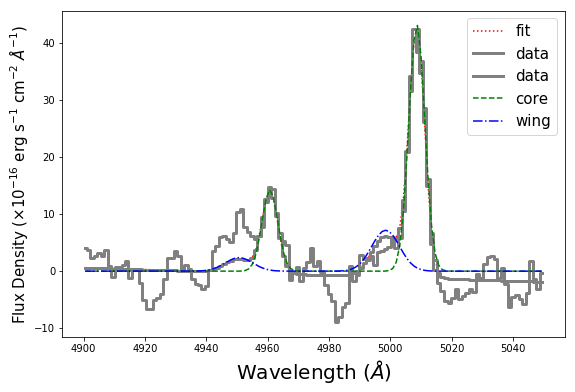

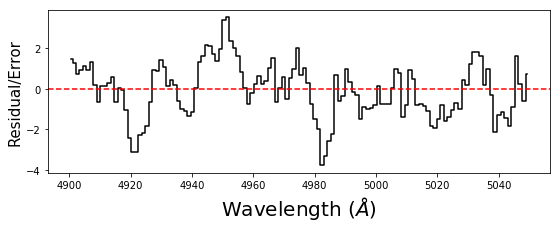

[  34.56484327  154.19027721  213.00962012    9.26526897 -441.17381791
  185.14623988  -13.49141264   67.073443  ] [   6.51553002   81.4880414    31.38759859    4.64491698  209.29366743
  100.75143733    3.22761115   16.11048758]
1694 53472 101
23.5061 39.9696985839 40.6933521037 0.00354358030102 43.6495876503 191.641 11.8966 0.046912


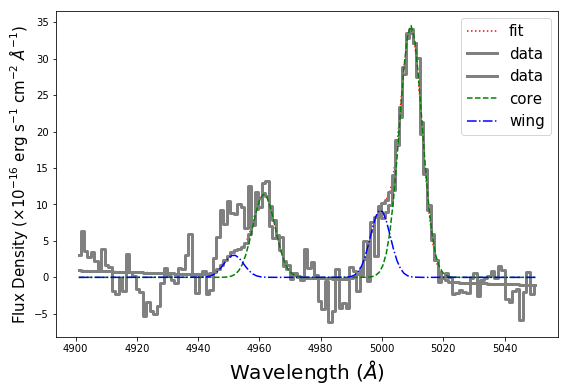

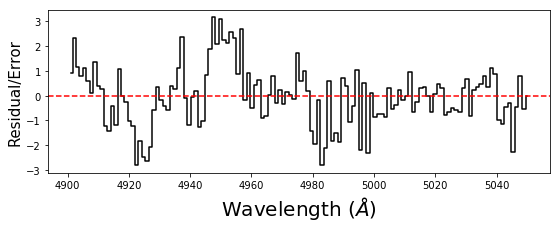

[  80.63437009  128.13020905  151.67247044   15.26765367 -534.78842754
  261.4775861   -42.95616313  212.81327457] [   7.94808662   56.30837628   20.51991528    7.10514529  121.84008819
   75.50773367    7.10654572   35.54506225]
2028 53818 060
22.6696 39.2889553646 39.89773745 0.00165080411736 43.0222110939 207.65 33.7048 0.0143849


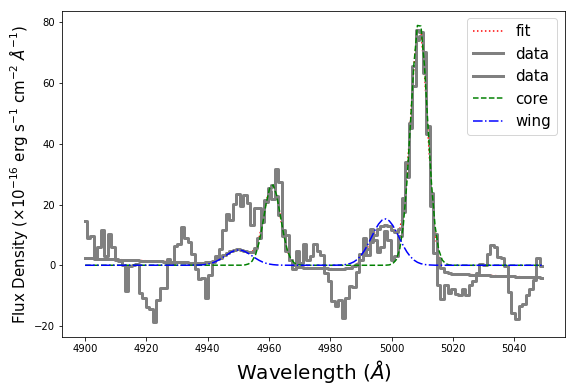

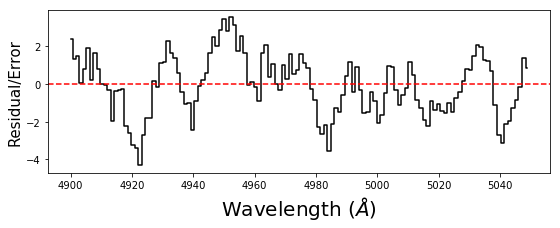

[  53.67590522   87.71408331  199.04232878   13.01312962 -459.45435211
  257.99614748  -24.49678102  121.08745144] [   8.33030092   78.72463351   23.87458975    6.89390345  167.03656673
   70.92664819    3.52330138   17.60672517]
2751 54243 012
23.0014 39.6020934415 40.2234350594 0.00246807812946 43.271065731 226.735 12.8468 0.02236


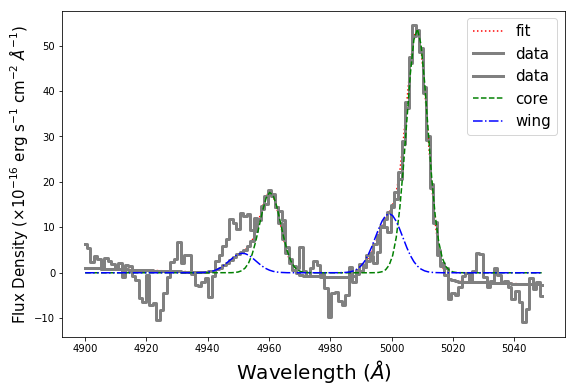

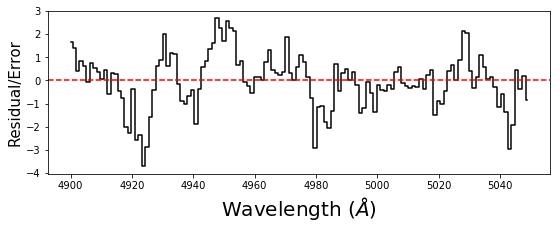

[  27.41912495  201.07164428  119.41947078   10.47920826 -117.2649407
  322.07541879   -5.33071292   26.39963107] [  1.7807557    7.68496191  10.51299067   1.32471613  47.16204445
  24.65497225   1.3533327    6.77779691]
0534 51997 235
23.2542 40.726777397 41.0211340109 0.00697071080884 43.4606700134 215.171 1.9919 0.0781911


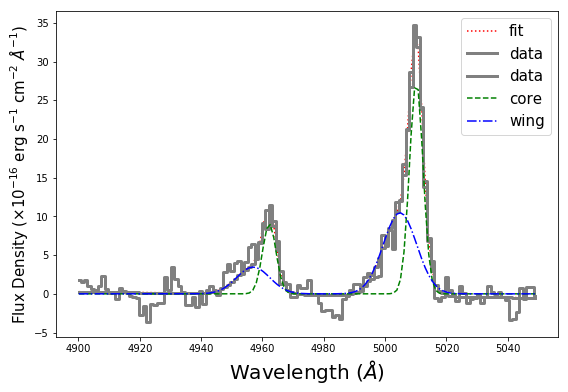

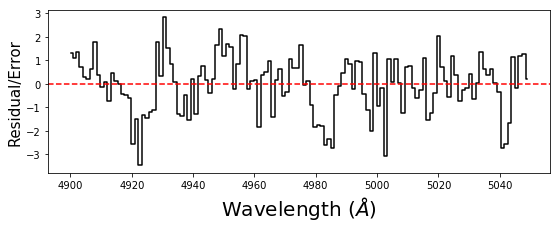

[  65.7488849   184.46972685  140.06403716   24.2371815   -90.44361804
  399.00199926  -22.79755895  112.10871487] [  5.67115825  24.0869422   26.4378246    4.55238922  82.9424578
  46.20384821   3.40395777  17.00293719]
1594 52992 566
22.93 40.0500800998 40.3404359124 0.00763086659681 43.2174673271 145.83 36.2478 0.0220662


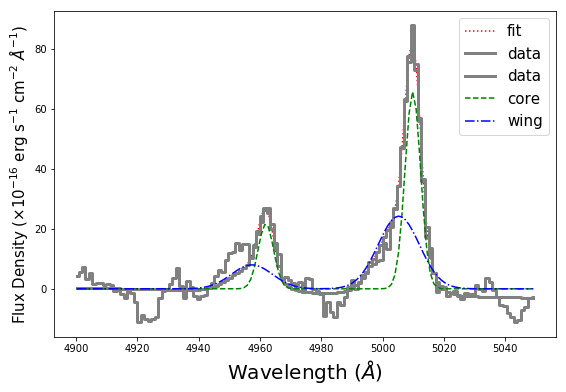

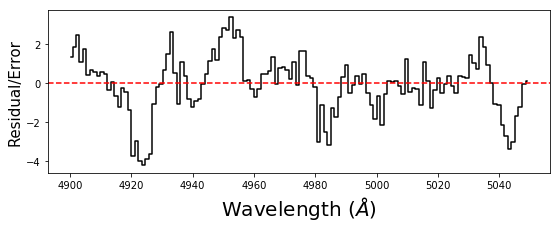

[  54.50901767 -358.75212283   73.55139482    8.29365502  -28.31933056
  310.07592274   -1.14031096    5.66536351] [  9.1817043   63.43043483  50.06265732   9.02726533  75.3695462
  52.34579587   0.92502371   4.62222166]
2097 53491 592
24.8219 41.5556559053 41.9635169669 0.00702472577824 44.63642313 177.921 33.6957 0.213594


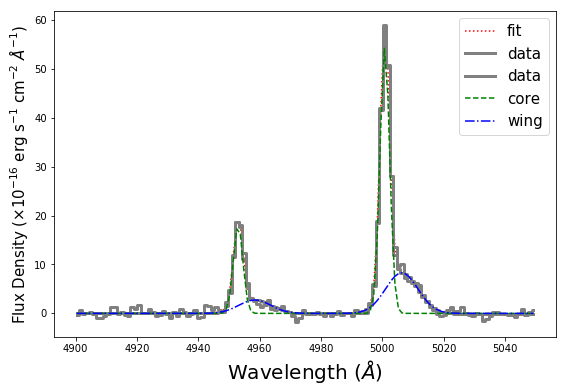

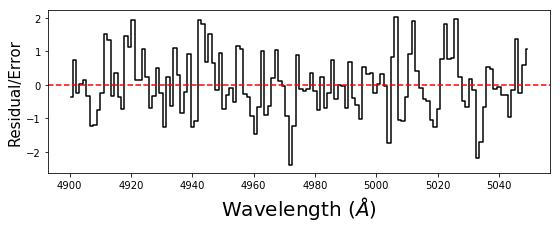

In [6]:
for i in range (len(PLATEID)):
    if int(PLATEID[i]/1000) ==0:
        a = '0%s'%(int(PLATEID[i]))
    else:
        a = int(PLATEID[i])
    if int(FIBERID[i]/100) ==0 and int(FIBERID[i]/10) > 0:
        b = ('0%s'%(int(FIBERID[i])))
    elif int(FIBERID[i]/10) ==0:
        b = ('00%s'%(int(FIBERID[i])))
    else:
        b = int(FIBERID[i])
    hdu = fits.open('raw/spectro/1d_26/%s/1d/spSpec-%s-%s-%s.fit'%(a,int(MJD[i]),a,b))
    dat = hdu[0].data
    header = hdu[0].header
    hdu.close()

    z = header['z']
    k=1+z
    data = dat[1]
    error = dat[2]
    wavestart = header['COEFF0']
    waveint = header['COEFF1'] 
    wo_wave = (10**(wavestart + waveint*np.arange(data.shape[0])))/k
      
    select_OIII5007 = (wo_wave>4997) & (wo_wave<5017)
    signal = np.mean(data[select_OIII5007])
    
    select_cont = (wo_wave>5090) & (wo_wave<5110)
    noise = np.std(data[select_cont])
    
    SN = signal/noise
    
    if SN > 3:
        (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,z)
        result_and_plot(wo_wave,data,error,z,popt_full_fit,parameters_err,a,int(MJD[i]),b,log_radio_power[i],vel_sigma_stellar[i],ra[i],dec[i])
    else:
        pass

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import curve_fit
from numpy import exp
from scipy import ndimage
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd

from shutil import copyfile



def script2(input_filename,output_filename):
    dir_name = '/home/u2/mainak/Downloads/LERG/Spectral Parameters'   
    os.chdir(dir_name)
    infiles = sorted(glob.glob(input_filename)) # './*source.fits'
    tabledict = {}
  
    for i, file in enumerate(infiles):
        hdulist = fits.open(file)
        bintab = hdulist[1].data
        table = Table(bintab)
        name = table['amp_OIII5007'][0]  
        tabledict[name] = table

    tab = vstack(list(tabledict.values()))
    df = tab.to_pandas()
    df = df.sort_values(by='amp_OIII5007', ascending=True)
    dtab = Table.from_pandas(df)
    dtab.write(output_filename, format='fits', overwrite=True)
    
script2(input_filename='./*_central_fit.fits',output_filename='LERG_model_par.fits')

In [13]:
def script2(input_filename,output_filename):
    dir_name = '/home/u2/mainak/Downloads/LERG/Big Table'   
    os.chdir(dir_name)
    infiles = sorted(glob.glob(input_filename)) # './*source.fits'
    tabledict = {}
  
    for i, file in enumerate(infiles):
        hdulist = fits.open(file)
        bintab = hdulist[1].data
        table = Table(bintab)
        name = table['RA'][0]  
        tabledict[name] = table

    tab = vstack(list(tabledict.values()))
    df = tab.to_pandas()
    df = df.sort_values(by='RA', ascending=True)
    dtab = Table.from_pandas(df)
    dtab.write(output_filename, format='fits', overwrite=True)
    
script2(input_filename='./*_spec_par.fits',output_filename='LERG_spec_par_full.fits')

In [3]:
import scipy
print(scipy.__version__)

0.19.1
